In [ ]:
import os
import numpy as np
import rawpy
from PIL import Image
import matplotlib.pyplot as plt
import imageio
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from collections import Counter
from google.colab import drive
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define directories
healthy_eye_dir = '/content/drive/My Drive/Data/Healthy'
bacterial_eye_dir = '/content/drive/My Drive/Data/Bacterial'

# Define the target size for ResNet50
target_size = (224, 224)

# Define the transformation pipeline for ResNet50
transform_pipeline = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_and_resize_images(root_folder, label, transform=None):
    images, labels, patients = [], [], []
    for patient_folder in os.listdir(root_folder):
        patient_path = os.path.join(root_folder, patient_folder)
        if os.path.isdir(patient_path):
            for filename in os.listdir(patient_path):
                img_path = os.path.join(patient_path, filename)
                try:
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.cr2')):
                        if filename.lower().endswith('.cr2'):
                            with rawpy.imread(img_path) as raw:
                                rgb = raw.postprocess()
                            img = Image.fromarray(rgb)
                        else:
                            img = Image.open(img_path)

                        if transform:
                            img = transform(img)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(label)
                        patients.append(patient_folder)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)
    patients = np.array(patients)

    return images, labels, patients

# Load and resize images for healthy and bacterial datasets
healthy_images, healthy_labels, healthy_patients = load_and_resize_images(healthy_eye_dir, label=0, transform=transform_pipeline)
bacterial_images, bacterial_labels, bacterial_patients = load_and_resize_images(bacterial_eye_dir, label=1, transform=transform_pipeline)


In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
#import numpy as np

# Function to split patients into train, validation, and test sets
def patient_split(patient_folders, train_size, val_size, test_size):
    np.random.shuffle(patient_folders)
    train_patients = patient_folders[:train_size]
    val_patients = patient_folders[train_size:train_size + val_size]
    test_patients = patient_folders[train_size + val_size:train_size + val_size + test_size]
    return train_patients, val_patients, test_patients

def filter_images_by_patients(images, labels, patients, selected_patients):
    mask = np.isin(patients, selected_patients)
    filtered_images = images[mask]
    filtered_labels = labels[mask]
    return filtered_images, filtered_labels

# Count the images per patient
healthy_patient_image_count = Counter(healthy_patients)
bacterial_patient_image_count = Counter(bacterial_patients)

# Get unique patient folders
healthy_patient_folders = sorted(healthy_patient_image_count.keys())
bacterial_patient_folders = sorted(bacterial_patient_image_count.keys())

# Split the healthy and bacterial patient folders
healthy_train_patients, healthy_val_patients, healthy_test_patients = patient_split(healthy_patient_folders, train_size=100, val_size=22, test_size=22)
bacterial_train_patients, bacterial_val_patients, bacterial_test_patients = patient_split(bacterial_patient_folders, train_size=90, val_size=20, test_size=20)

# Filter images by patients
X_train_healthy, y_train_healthy = filter_images_by_patients(healthy_images, healthy_labels, healthy_patients, healthy_train_patients)
X_val_healthy, y_val_healthy = filter_images_by_patients(healthy_images, healthy_labels, healthy_patients, healthy_val_patients)
X_test_healthy, y_test_healthy = filter_images_by_patients(healthy_images, healthy_labels, healthy_patients, healthy_test_patients)

X_train_bacterial, y_train_bacterial = filter_images_by_patients(bacterial_images, bacterial_labels, bacterial_patients, bacterial_train_patients)
X_val_bacterial, y_val_bacterial = filter_images_by_patients(bacterial_images, bacterial_labels, bacterial_patients, bacterial_val_patients)
X_test_bacterial, y_test_bacterial = filter_images_by_patients(bacterial_images, bacterial_labels, bacterial_patients, bacterial_test_patients)

# Combine the healthy and bacterial datasets for train, validation, and test sets
X_train = np.concatenate((X_train_healthy, X_train_bacterial), axis=0)
y_train = np.concatenate((y_train_healthy, y_train_bacterial), axis=0)

X_val = np.concatenate((X_val_healthy, X_val_bacterial), axis=0)
y_val = np.concatenate((y_val_healthy, y_val_bacterial), axis=0)

X_test = np.concatenate((X_test_healthy, X_test_bacterial), axis=0)
y_test = np.concatenate((y_test_healthy, y_test_bacterial), axis=0)

# Shuffle the combined arrays to ensure a random distribution
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

val_indices = np.arange(X_val.shape[0])
np.random.shuffle(val_indices)
X_val = X_val[val_indices]
y_val = y_val[val_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"Train images shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test images shape: {X_test.shape}, Test labels shape: {y_test.shape}")


Train images shape: (1862, 3, 224, 224), Train labels shape: (1862,)
Validation images shape: (388, 3, 224, 224), Validation labels shape: (388,)
Test images shape: (433, 3, 224, 224), Test labels shape: (433,)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 0.0773, Train Accuracy: 0.9710, Val Loss: 1.3354, Val Accuracy: 0.8351
Epoch 2/50, Train Loss: 0.0128, Train Accuracy: 0.9952, Val Loss: 0.0439, Val Accuracy: 0.9768
Epoch 3/50, Train Loss: 0.1047, Train Accuracy: 0.9715, Val Loss: 2.5510, Val Accuracy: 0.7577
Epoch 4/50, Train Loss: 0.0242, Train Accuracy: 0.9919, Val Loss: 0.2080, Val Accuracy: 0.8892
Epoch 5/50, Train Loss: 0.0431, Train Accuracy: 0.9855, Val Loss: 0.1703, Val Accuracy: 0.9407
Epoch 6/50, Train Loss: 0.0084, Train Accuracy: 0.9979, Val Loss: 0.0160, Val Accuracy: 0.9923
Epoch 7/50, Train Loss: 0.0075, Train Accuracy: 0.9968, Val Loss: 0.0058, Val Accuracy: 0.9974
Epoch 8/50, Train Loss: 0.0130, Train Accuracy: 0.9936, Val Loss: 0.0501, Val Accuracy: 0.9794
Epoch 9/50, Train Loss: 0.0040, Train Accuracy: 0.9995, Val Loss: 0.1035, Val Accuracy: 0.9820
Epoch 10/50, Train Loss: 0.0018, Train Accuracy: 0.9995, Val Loss: 0.0319, Val Accuracy: 0.9845
Epoch 11/50, Train Loss: 0.0069, Train Accuracy: 

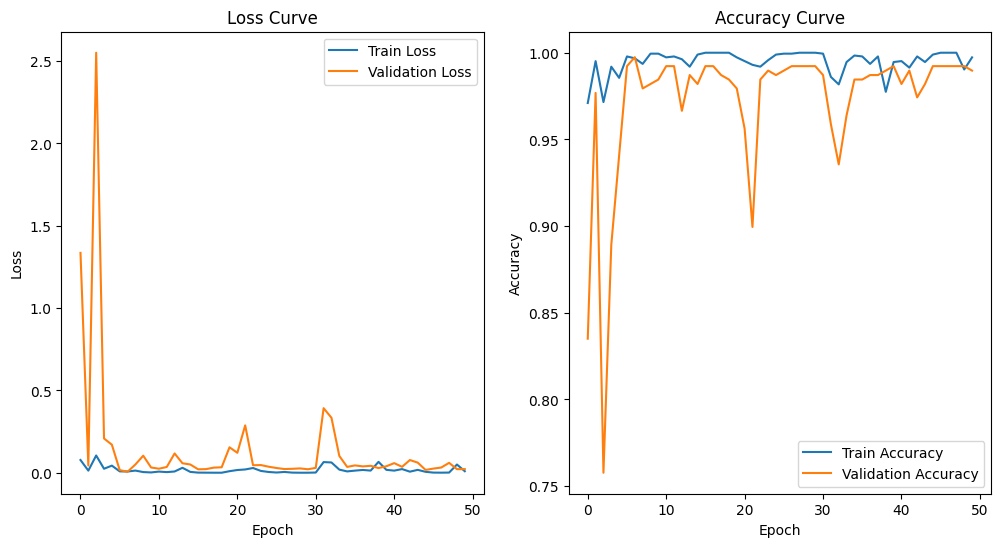

In [ ]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Load ResNet50 model pre-trained on ImageNet
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjusting the final layer for 2 classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize lists to save loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate_model(val_loader)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the trained model
# torch.save(model.state_dict(), '/content/drive/My Drive/Data/resnet50_model.pth')

# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


Sensitivity: 0.9911
Specificity: 1.0000
Accuracy: 0.9954


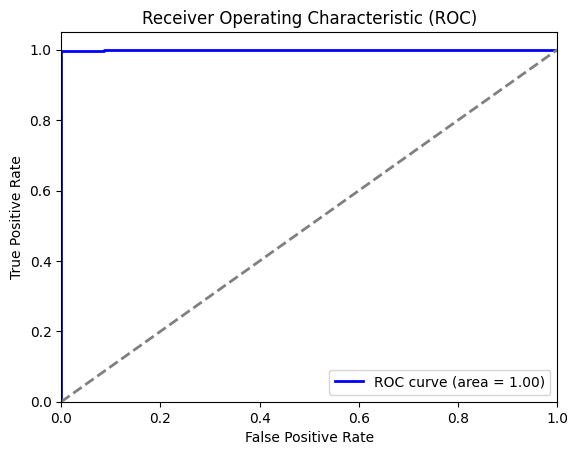

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import torch
import torch.nn.functional as F

# Define function to calculate sensitivity, specificity, and accuracy
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    accuracy = accuracy_score(y_true, y_pred)  # Overall accuracy
    return sensitivity, specificity, accuracy

# Define function to plot ROC curve and calculate AUC
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model on the test set
model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

# Calculate metrics
sensitivity, specificity, accuracy = calculate_metrics(y_true, y_pred)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plot ROC curve and calculate AUC
plot_roc_curve(y_true, y_scores)


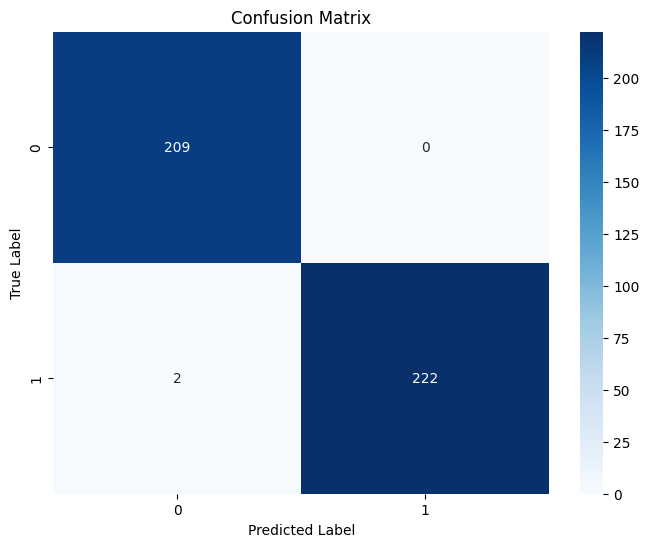

In [ ]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


labels = [0, 1]
plot_confusion_matrix(y_true, y_pred, labels)
